In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');
import Calculate_ABA_Flinkelsteinlab as CalcABA
reload(CalcABA)
import sys 
sys.path.append('../code_general/')
from CRISPR_free_energy_landscape import unpack_parameters
import CRISPR_free_energy_landscape as FreeEnergy
reload(FreeEnergy);

In [2]:
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)

## Model energy lanscape for [Cas] = 1 nM (reference concentration)

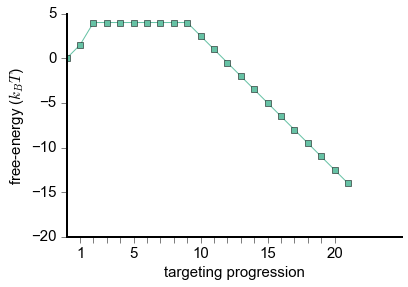

In [3]:
model_id='init_limit_lock_const_EpsI'

e_PAM = 1.5
ec_1 = -2.5
ec_first = 0.0
ec_second = 1.5
e_I = 5.0
x = 8 
k_PAM = 100.0
E_barr = -ec_1
k = 1.0

parameters = [e_PAM, ec_1, ec_first, ec_second, e_I, x, k_PAM, E_barr, k]

Energy_landscape = FreeEnergy.plot_landscape(parameters, model_id=model_id);
plt.ylim([-20, 5]);
Free_Energy = -np.log(np.cumsum(np.exp(-np.array(Energy_landscape[1:]))))

## Estimating the effective on-rate for the actual target
### Note: only works if PAM binding equilibrates before the R-loop nucleation. Also it is implicitly assumed that the Rloop progression dynamics is fast compared to initiation, and Cas9-target complex is stable enough once the Rloop is fully formed (i.e. large barrier to unbind from the last state).

Parameters are adjusted so that the corresponding lifetime is 10 minutes. The fast increase of the bound fraction in the beginning is due to the PAM equilibration

In [4]:
delta_landscape = np.copy(Energy_landscape[2:])
delta_landscape = delta_landscape-delta_landscape[0]
P_reject = 1.0/(np.sum(np.exp(delta_landscape))+1)
kon_eff = 1.0/(1+np.exp(e_PAM))*np.exp(-E_barr)*k*P_reject
Ton_eff = 1.0/kon_eff

In [5]:
concentrations = 2**np.array(range(0,11))*0.5

reference = 1;

concentration = 1

T_list = list(np.arange(0,5*Ton_eff,100))

P = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=[], T_list=T_list, model_id=model_id)

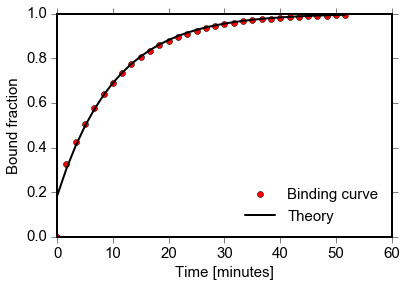

In [6]:
plt.plot(map(lambda t: float(t)/60, T_list), P, 'ro', mfc='r', label='Binding curve')
plt.plot(map(lambda t: float(t)/60, T_list), 
         map(lambda t: (1-np.exp(-kon_eff*t))+(1.0/(1+np.exp(e_PAM)))*np.exp(-kon_eff*t),T_list), 
         'k-', label='Theory', lw=2)
plt.legend(loc=4, fontsize=15)
plt.xlabel('Time [minutes]')
plt.ylabel('Bound fraction')

## Binding curves for off targets which have blocks of mismatches of different lengths.

In [7]:
P_B1 = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=range(1,20), T_list=T_list, model_id=model_id)
P_B5 = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=range(5,20), T_list=T_list, model_id=model_id)
P_B10 = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=range(10,20), T_list=T_list, model_id=model_id)
P_B12 = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=range(12,20), T_list=T_list, model_id=model_id)

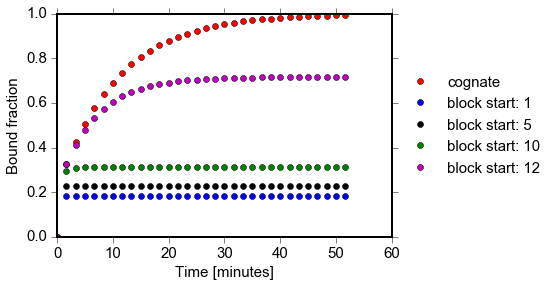

In [8]:
plt.plot(map(lambda t: float(t)/60, T_list), P, 'ro', mfc='r', label='cognate')
plt.plot(map(lambda t: float(t)/60, T_list), P_B1, 'bo', mfc='b', label='block start: 1')
plt.plot(map(lambda t: float(t)/60, T_list), P_B5, 'ko', mfc='k', label='block start: 5')
plt.plot(map(lambda t: float(t)/60, T_list), P_B10, 'go', mfc='g', label='block start: 10')
plt.plot(map(lambda t: float(t)/60, T_list), P_B12, 'mo', mfc='m', label='block start: 12')
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', fontsize=15, bbox_to_anchor=(legend_x, legend_y))
plt.xlabel('Time [minutes]')
plt.ylabel('Bound fraction')

## ABA for mismatch blocks 

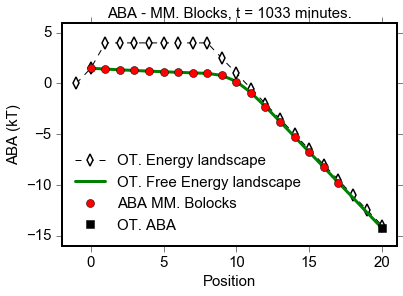

In [9]:
T = 100*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

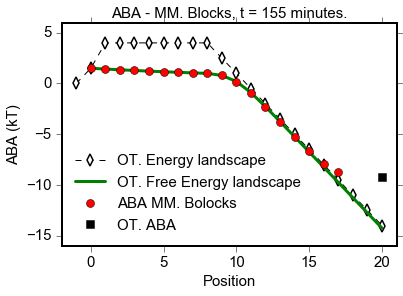

In [10]:
T = 15*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

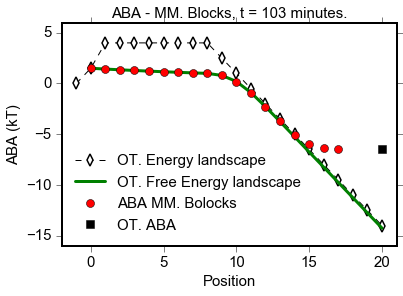

In [11]:
T = 10*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

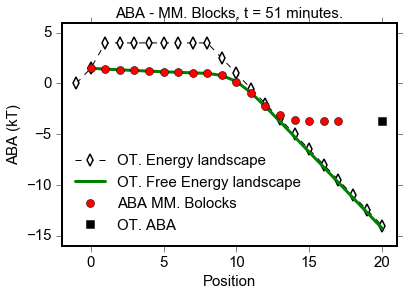

In [12]:
T = 5*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

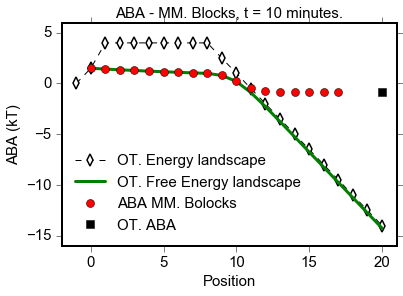

In [13]:
T = 1*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

### The effect of changing the Rloop initiation barrier (i.e. E_barr, ec_1)
We temporarily increase E_barr by 1 kT here

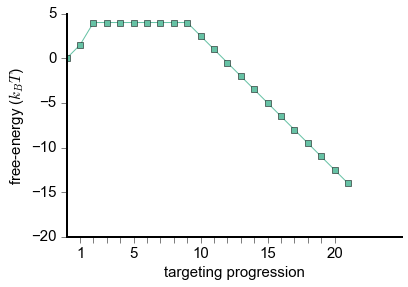

In [14]:
new_parameters = [e_PAM, ec_1-1, ec_first, ec_second, e_I, x, k_PAM, E_barr+1, k]
new_Energy_landscape = FreeEnergy.plot_landscape(parameters, model_id=model_id)
plt.ylim([-20, 5]);
new_Free_Energy = -np.log(np.cumsum(np.exp(-np.array(new_Energy_landscape[1:]))))

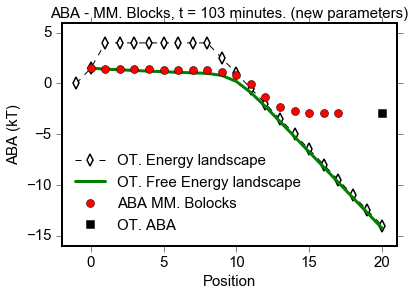

In [15]:
T = 10*Ton_eff

Block_list = range(1,19)

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)

ABA_list = map(ABA_Block, Block_list)


ABA_Block = lambda B: CalcABA.calc_ABA(new_parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)

new_ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, new_ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-16, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes. (new parameters)'
plt.title(title_str, fontsize=15)

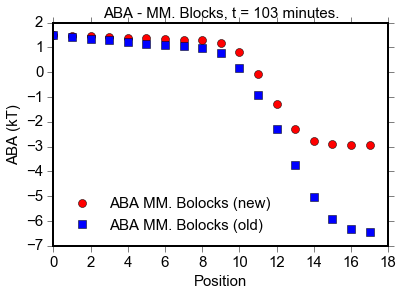

In [16]:
plt.plot(np.array(Block_list)-1, new_ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks (new)', ms=8)
plt.plot(np.array(Block_list)-1, ABA_list, 'bs', mfc='b', label='ABA MM. Bolocks (old)', ms=8)
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

### $\Delta$ABA map for all possible blocks (at t = 51 minutes)

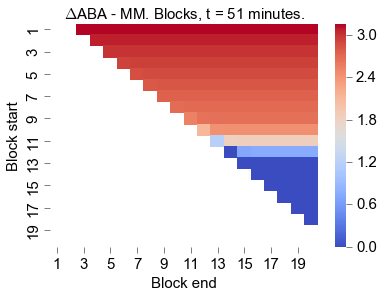

In [17]:
T = 5*Ton_eff

ABA_OT = map(ABA_Block, [21])[0]
ABA_Max = map(ABA_Block, range(1,21))[0]

Ng = 20;
block_mm_map = np.empty((Ng,Ng))
block_mm_map[:] = np.nan

for bs in range(1,Ng-1):
    for be in range(bs+2,Ng+1):
        block_mm_map[bs-1,be-1] = CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(bs,be), 
                           model_id = model_id, guide_length = 20, T=T)- ABA_OT

plt.figure();
sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=0,vmax=ABA_Max-ABA_OT)
plt.xlabel('Block end', fontsize=15)
plt.ylabel('Block start', fontsize=15)
title_str = '$\Delta$ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)
ax = plt.gca();
ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+1));
ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+1));
    

### $\Delta$ABA map for double mismatches (at t = 42 minutes)

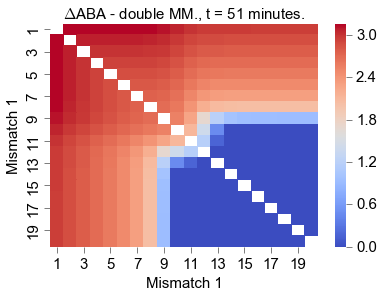

In [18]:
T = 5*Ton_eff

ABA_OT = map(ABA_Block, [21])[0]
ABA_Max = map(ABA_Block, range(1,21))[0]

Ng = 20;
double_mm_map = np.empty((Ng,Ng))
double_mm_map[:] = np.nan

for i in range(1,Ng):
    for j in range(i+1,Ng+1):
        double_mm_map[i-1,j-1] = CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=[i,j], 
                           model_id = model_id, guide_length = 20, T=T)- ABA_OT
        double_mm_map[j-1,i-1] = double_mm_map[i-1,j-1]

plt.figure();
sns.heatmap(double_mm_map, cmap='coolwarm',cbar=True,vmin=0,vmax=ABA_Max-ABA_OT)
plt.xlabel('Mismatch 1', fontsize=15)
plt.ylabel('Mismatch 1', fontsize=15)
title_str = '$\Delta$ABA - double MM., t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)
ax = plt.gca();
ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+1));
ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+1));

# New model energy landscape with two drops  (reference concentration: 1nM)

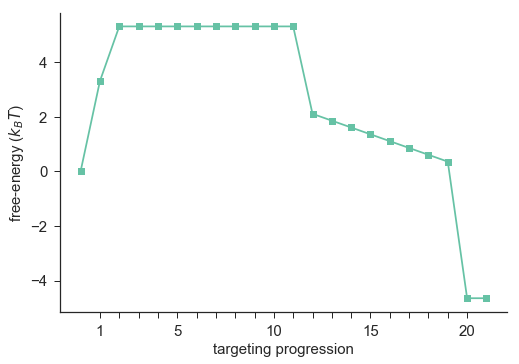

In [111]:
model_id = 'init_limit_two_drops'

e_PAM = 1+np.log(10)
ec_1 = -2
ec_first = 0.0
drop1 = 3.2
ec_second = 0.25
drop2 = 5
ec_third = 0.0
pos1 = 10
pos2 = 18
e_I = 4
k_PAM = 100.0
E_barr = -ec_1
k = 0.6

parameters = [e_PAM,ec_1,ec_first,drop1,ec_second,drop2,ec_third,pos1,pos2,e_I,k_PAM,E_barr,k]

Energy_landscape = FreeEnergy.plot_landscape(parameters, model_id=model_id);
#plt.ylim([-20, 5]);
Free_Energy = -np.log(np.cumsum(np.exp(-np.array(Energy_landscape[1:]))))

## Estimating the effective on-rate for the actual target
### Note: only works if PAM binding equilibrates before the R-loop nucleation. Also it is implicitly assumed that the Rloop progression dynamics is fast compared to initiation, and Cas9-target complex is stable enough once the Rloop is fully formed (i.e. large barrier to unbind from the last state).

Parameters are adjusted so that the corresponding lifetime is 10 minutes. The fast increase of the bound fraction in the beginning is due to the PAM equilibration

In [112]:
delta_landscape = np.copy(Energy_landscape[2:])
delta_landscape = delta_landscape-delta_landscape[0]
P_reject = 1.0/(np.sum(np.exp(delta_landscape))+1)
kon_eff = 1.0/(1+np.exp(e_PAM))*np.exp(-E_barr)*k*P_reject
Ton_eff = 1.0/kon_eff

In [113]:
concentrations = 2**np.array(range(0,11))*0.5

reference = 1;

concentration = 1
 
T_list = list(np.arange(0,5*Ton_eff,100))

P = CalcABA.calc_binding_curve(parameters, concentration, reference, mismatch_positions=[], T_list=T_list, model_id=model_id)

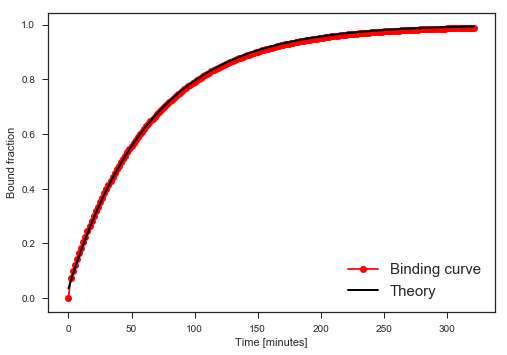

In [114]:
plt.plot(map(lambda t: float(t)/60, T_list), P, 'r-o', mfc='r', label='Binding curve')
plt.plot(map(lambda t: float(t)/60, T_list), 
         map(lambda t: (1-np.exp(-kon_eff*t))+(1.0/(1+np.exp(e_PAM)))*np.exp(-kon_eff*t),T_list), 
         'k-', label='Theory', lw=2)
plt.legend(loc=4, fontsize=15)
plt.xlabel('Time [minutes]')
plt.ylabel('Bound fraction')

## ABA for mismatch blocks 

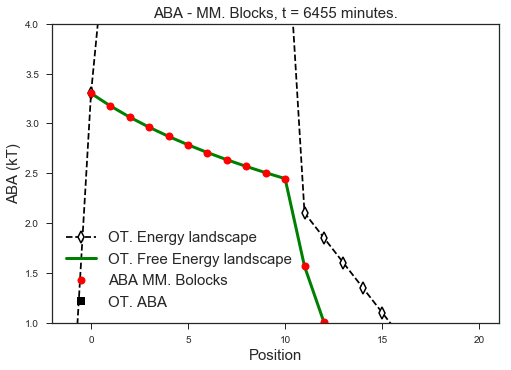

In [110]:
T = 100*Ton_eff

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([1, 4])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

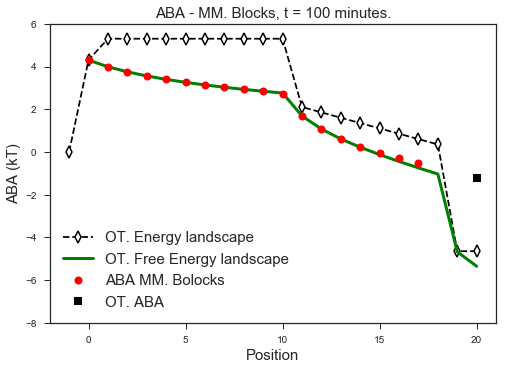

In [58]:
T = 6000

ABA_Block = lambda B: CalcABA.calc_ABA(parameters, concentrations, reference, mismatch_positions=range(B,21), 
                           model_id = model_id, guide_length = 20, T=T)
Block_list = range(1,19)

ABA_list = map(ABA_Block, Block_list)

ABA_OT = map(ABA_Block, [21])

plt.plot(range(-1,21), Energy_landscape, 'kd--', mfc='w', mec='k', mew=1.5, ms=8,label='OT. Energy landscape')
plt.plot(range(0,21), Free_Energy, 'g-', label='OT. Free Energy landscape', lw=3)
plt.plot(np.array(Block_list)-1, ABA_list, 'ro', mfc='r', label='ABA MM. Bolocks', ms=8)
plt.plot([20], ABA_OT, 'ks', mfc='k', mec='k', ms=8,label='OT. ABA')
plt.ylim([-8, 6])
plt.xlim([-2, 21])
plt.xlabel('Position', fontsize=15)
plt.ylabel('ABA (kT)', fontsize=15)
plt.legend(loc=3, fontsize=15)
title_str = 'ABA - MM. Blocks, t = ' + str(int(T/60)) + ' minutes.'
plt.title(title_str, fontsize=15)

In [51]:
Ton_eff/60

64.552499833371925